In [3]:
import pandas as pd
import numpy as np
import perception.util.conversion as conv
import os
import cv2
import scipy
import math
import seaborn as sns
import statsmodels.api as sm
import ground_truth_real
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

plt.style.use("seaborn-v0_8")

### Import and process BEV and tracking poses

In [4]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
run1_path = f'{experiments_dir}/run1'
run2_path = f'{experiments_dir}/run2'
run3_path = f'{experiments_dir}/run3'

bev_paths_run1 = [f'{run1_path}/bev/{f}' for f in os.listdir(f'{run1_path}/bev') if os.path.isdir(f'{run1_path}/bev/{f}')]
bev_paths_run2 = [f'{run2_path}/bev/{f}' for f in os.listdir(f'{run2_path}/bev') if os.path.isdir(f'{run2_path}/bev/{f}')]

tracking_paths_run1 = [f'{run1_path}/ego/{f}/color' for f in os.listdir(f'{run1_path}/ego') if os.path.isdir(f'{run1_path}/ego/{f}')]
tracking_paths_run2 = [f'{run2_path}/ego/{f}/color' for f in os.listdir(f'{run2_path}/ego') if os.path.isdir(f'{run2_path}/ego/{f}')]

In [ ]:
run1_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run1, tracking_paths_run1))
run2_data = ground_truth_real.process_run_data(ground_truth_real.read_all_runs(bev_paths_run2, tracking_paths_run2))

### Test difference with pose estimation on distorted and undistorted images

In [21]:
side_length = 0.25
half_side_length = side_length / 2

# Define the 4 corners of the ArUco marker
marker_obj_points = np.array([[
    [-half_side_length, half_side_length, 0],
    [half_side_length, half_side_length, 0],
    [half_side_length, -half_side_length, 0],
    [-half_side_length, -half_side_length, 0]
]], dtype=np.float32)

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_APRILTAG

[[699.1550293    0.         616.29498291]
 [  0.         699.1550293  337.13299561]
 [  0.           0.           1.        ]]
[[539.69103074   0.         608.57115171]
 [  0.         536.57228887 334.91476812]
 [  0.           0.           1.        ]]


(array([5], dtype=int32),
 array([4], dtype=int32),
 array([4], dtype=int32),
 array([[-0.18651478],
        [-0.21729436],
        [ 2.74087605]]),
 (-179.49883416883017, -0.5511487594395152, -60.833567240920594),
 array([[-2.57101694],
        [ 0.37167125],
        [ 2.68471579]]),
 (179.54575293750247, 0.19873510738440445, -166.59629475145627),
 array([[-2.57101837],
        [ 0.37167151],
        [ 2.68471745]]),
 (179.54585322990005, 0.1986908608669305, -166.59630933374086))

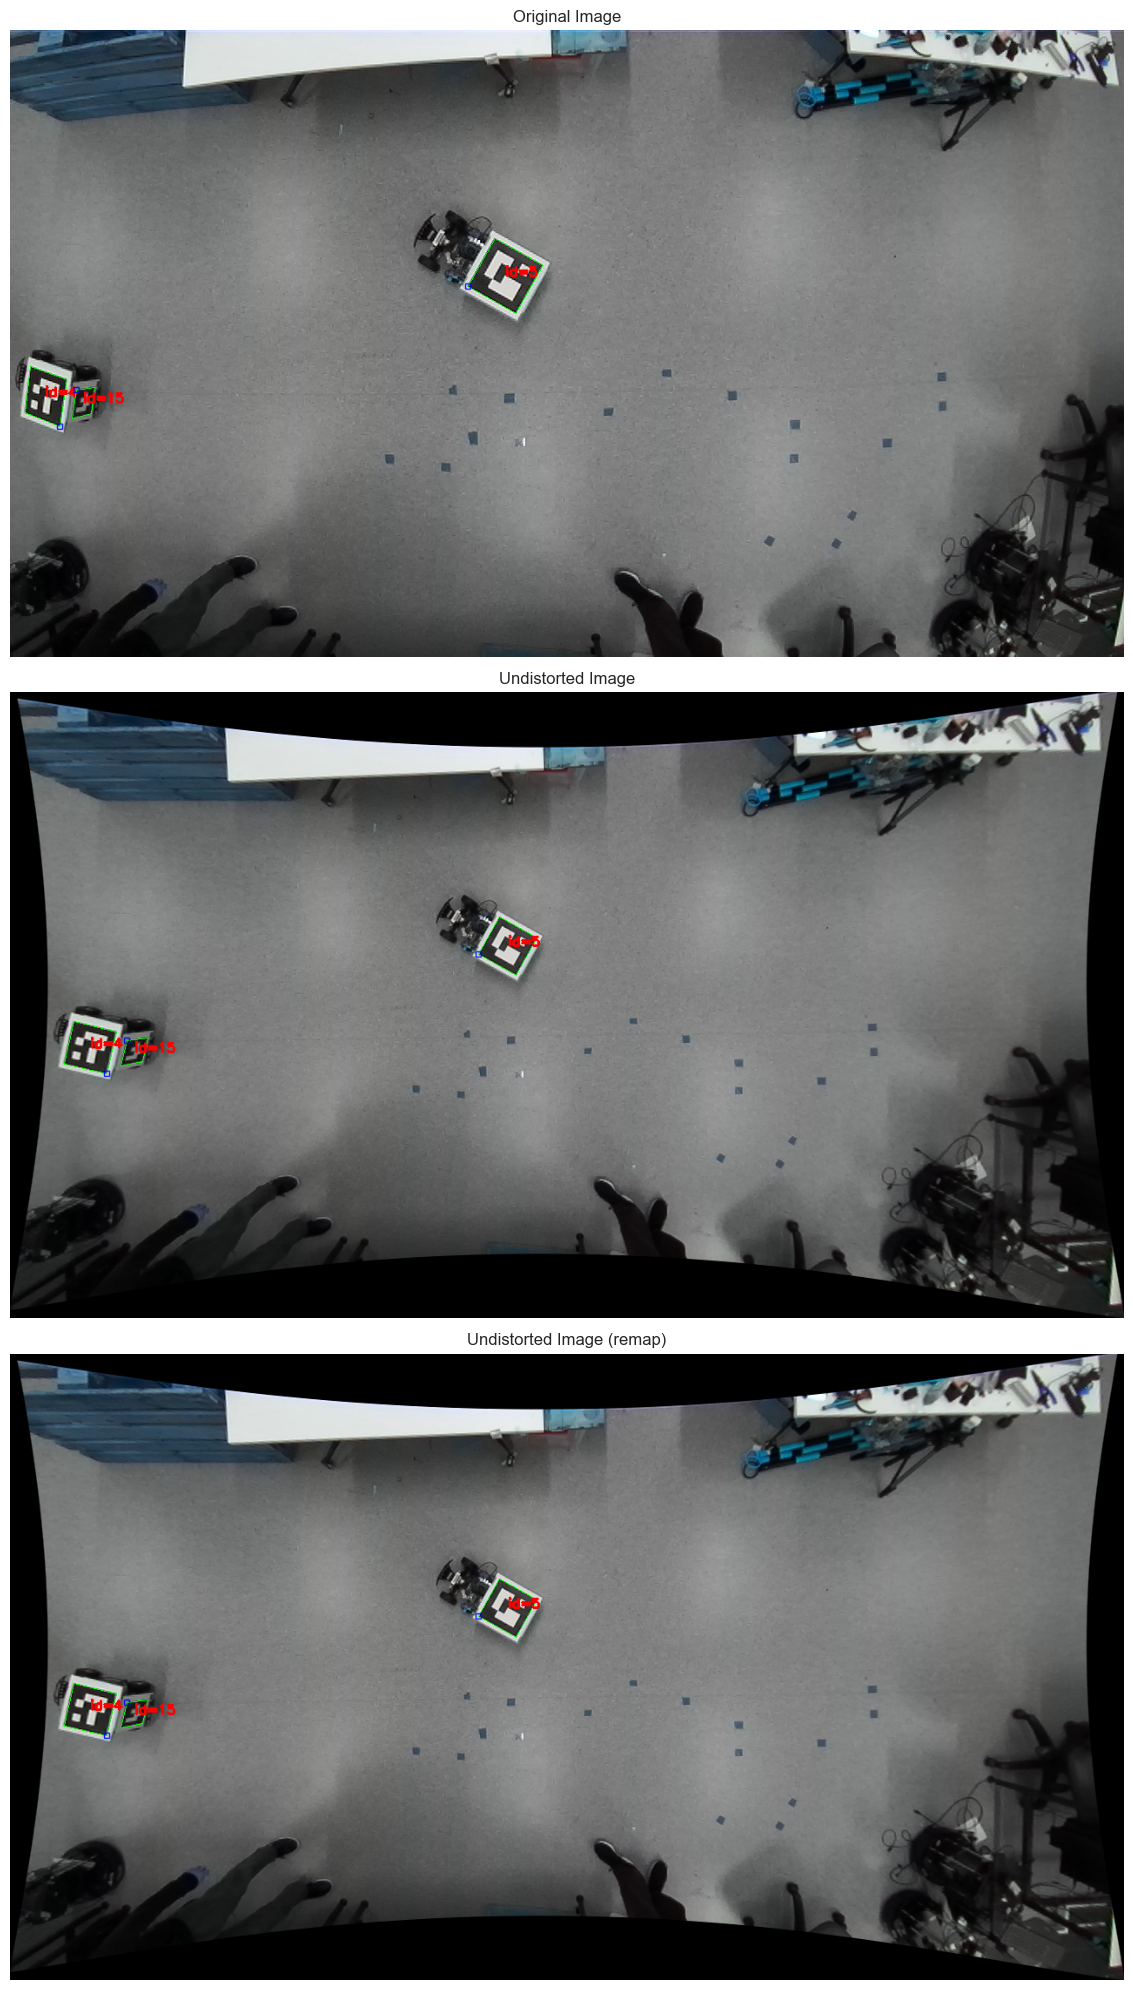

In [25]:
image = cv2.imread(f'{run3_path}/bev/24_09_29_22:45:40/bev/left/1727603151901157814.png')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

intrinsics = np.loadtxt(f'{run3_path}/bev/24_09_29_22:45:40/bev/left/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run3_path}/bev/24_09_29_22:45:40/bev/left/dist_coeffs.txt')

new_img_size = (int(image.shape[1] * 1.2), int(image.shape[0] * 1.2))
# not specifying new image size
new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)

# specifying new image size
new_intrinsics2, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
mapx, mapy = cv2.initUndistortRectifyMap(intrinsics, dist_coeffs, None, new_intrinsics, image.shape[:2][::-1], m1type=cv2.CV_32FC1)
undistorted_image2 = cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)

und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)
und2_corners, und2_ids, _ = cv2.aruco.detectMarkers(undistorted_image2, dictionary, parameters=detector_params)
corners, ids, _ = cv2.aruco.detectMarkers(image, dictionary, parameters=detector_params)

_, rvec_und, tvec_und = cv2.solvePnP(marker_obj_points, und_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und), degrees=True)

_, rvec_und2, tvec_und2 = cv2.solvePnP(marker_obj_points, und2_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und2 = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und2), degrees=True)

_, rvec, tvec = cv2.solvePnP(marker_obj_points, corners[0], intrinsics, dist_coeffs,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec), degrees=True)

image_draw = cv2.aruco.drawDetectedMarkers(image.copy(), corners, ids)
und_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)
und2_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image2.copy(), und2_corners, und2_ids)

plt.figure(figsize=(12, 20))
plt.subplot(3, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(image_draw)
plt.title("Original Image")
plt.subplot(3, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(und_image_draw)
plt.title("Undistorted Image")
plt.subplot(3, 1, 3)
plt.grid(False)
plt.axis('off')
plt.imshow(und2_image_draw)
plt.title("Undistorted Image (remap)")
plt.tight_layout()

print(intrinsics)
print(new_intrinsics)

ids[0], und_ids[0],  und2_ids[0], tvec, euler, tvec_und, euler_und, tvec_und2, euler_und2

### Sanity checking conversions

In [260]:
rvec = run1_data[7]["ego_bev_right_df"][["ax", "ay", "az"]].values[0]
euler = run1_data[7]["ego_bev_right_df"][["roll", "pitch", "yaw"]].values[0]
quat = run1_data[7]["ego_bev_right_df"][["qx", "qy", "qz", "qw"]].values[0]

print("rvecs")
print(rvec, conv.get_rodrigues_from_euler(*euler, degrees=True), sep="\n")

print("quats")
print(conv.get_quaternion_from_rodrigues(rvec), conv.get_quaternion_from_euler(*euler, degrees=True), sep="\n")

print("rotation matrices")
print(conv.get_rotation_matrix_from_quaternion(*quat), cv2.Rodrigues(rvec)[0], conv.get_rotation_matrix_from_euler(*euler, degrees=True), sep="\n")

print("euler angles")
print(conv.get_euler_from_quaternion(*quat), conv.get_euler_from_rotation_matrix(conv.get_rotation_matrix_from_quaternion(*quat)), sep="\n")

rvecs
[ 3.02389585  0.82590038 -0.0376079 ]
[ 3.02389585  0.82590038 -0.0376079 ]
quats
[ 0.9645916   0.26345371 -0.01199653  0.00335638]
(0.9645916035702194, 0.2634537080875546, -0.011996530972061293, 0.003356376228394645)
rotation matrices
[[ 8.60896454e-01  5.08330999e-01 -2.13750066e-02]
 [ 5.08169940e-01 -8.61161757e-01 -1.27961258e-02]
 [-2.49120056e-02  1.54003519e-04 -9.99689636e-01]]
[[ 8.60896454e-01  5.08330999e-01 -2.13750066e-02]
 [ 5.08169940e-01 -8.61161757e-01 -1.27961258e-02]
 [-2.49120056e-02  1.54003519e-04 -9.99689636e-01]]
[[ 8.60896454e-01  5.08330999e-01 -2.13750066e-02]
 [ 5.08169940e-01 -8.61161757e-01 -1.27961258e-02]
 [-2.49120056e-02  1.54003519e-04 -9.99689636e-01]]
euler angles
(3.1414386022599086, 0.02491458310644168, 0.5332417680518773)
(3.1414386022599086, 0.0249145831064419, 0.5332417680518773)


### Cross-validation on the model

In [176]:
models = []

class SMWrapper(BaseEstimator, RegressorMixin):
  """ A universal sklearn-style wrapper for statsmodels regressors """
  def __init__(self, model_class, degree=10):
    self.model_class = model_class
    self.degree = degree
    
  def fit(self, X, y):
    self.model_, _, _ = ground_truth_real.fit_polynomial(X, y, self.degree)
    models.append(self.model_)
    return self
  
  def predict(self, X: np.ndarray):
    polynomial_features= PolynomialFeatures(degree=self.degree)
    X = X.reshape(-1, 1)
    xp = polynomial_features.fit_transform(X)
    
    return self.model_.predict(xp)
  
  def get_models(self):
    return self.models

In [179]:
cross_val_wrapper = SMWrapper(sm.OLS, degree=10)
cross_val_score(cross_val_wrapper, run1_data[0]["ego_bev_right_df"]["time_norm (sec)"].values, run1_data[0]["ego_bev_right_df"]["tx"], scoring='r2', cv=5)

array([-135.62495632,    0.99755756,    0.99879018,    0.99938573,
        -18.25723485])

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tx'>

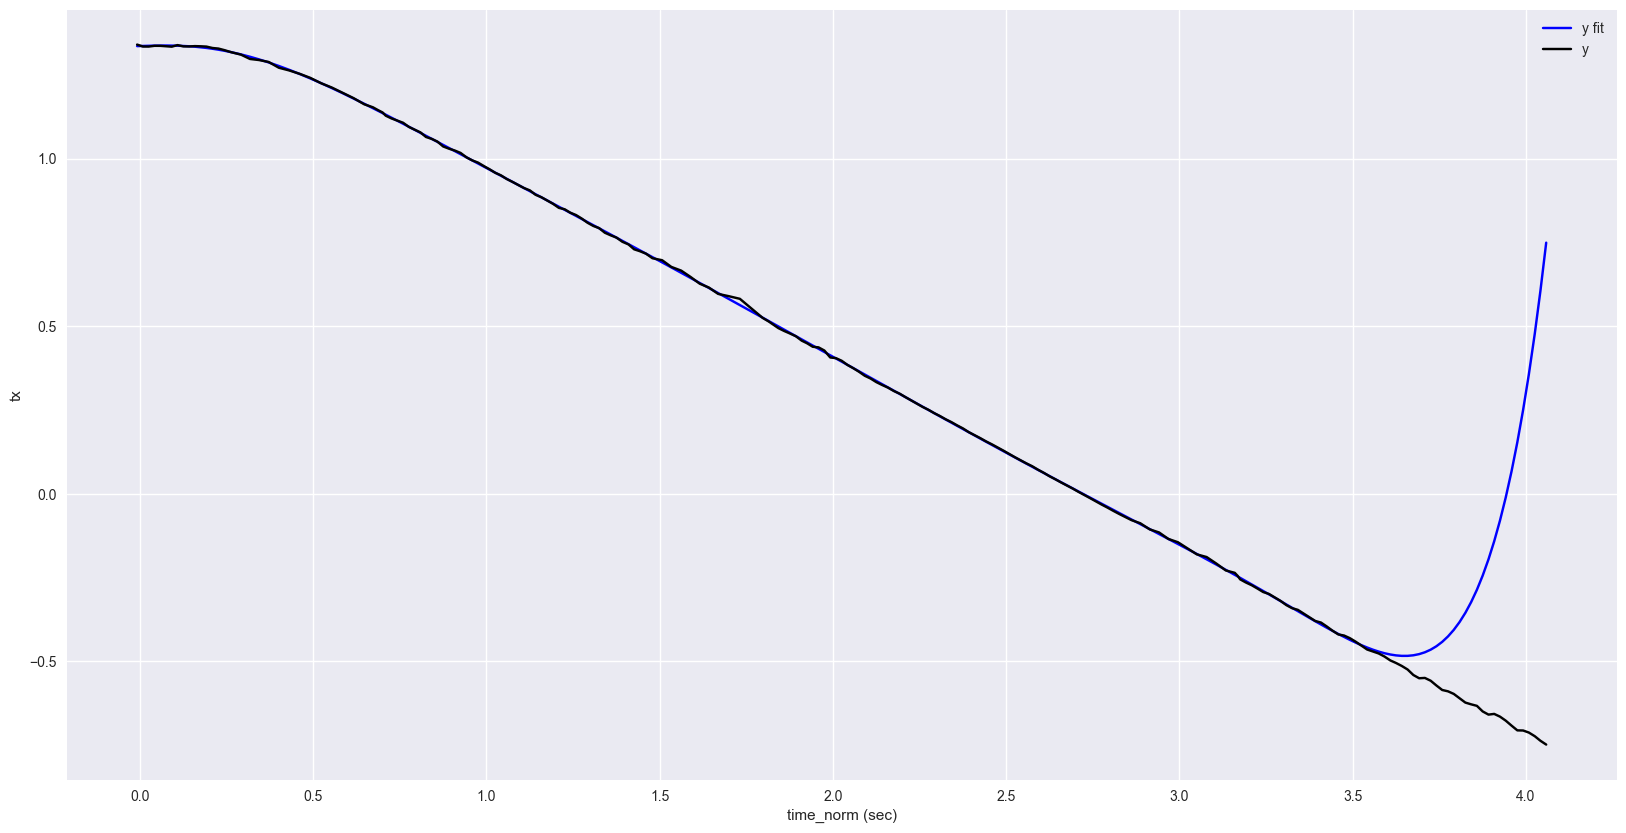

In [181]:
plt.figure(figsize=(20, 10))

# Show cross-validation results
polynomial_features= PolynomialFeatures(degree=10)
x = run1_data[0]["ego_bev_right_df"]['time_norm (sec)'].values.reshape(-1, 1)
xp = polynomial_features.fit_transform(x)

plt.plot(x, models[4].predict(xp), label='y fit', markersize='5', color='blue')
sns.lineplot(data=run1_data[0]["ego_bev_right_df"], x='time_norm (sec)', y='tx', label='y', color='black')

In [261]:
class PolynomialParams:
  def __init__(self, df_name, x, y, degree):
    self.df_name = df_name
    self.x = x
    self.y = y
    self.degree = degree

def fit_polynomial_models(run_data, params: list[PolynomialParams]):
  for run in run_data:
    run["models"] = {}

    for param in params:
      model, model_deriv, model_2nd_deriv = ground_truth_real.fit_polynomial(
        run[param.df_name][param.x].values, 
        run[param.df_name][param.y].values, param.degree)
      if param.df_name not in run["models"]:
        run["models"][param.df_name] = {}
      
      run["models"][param.df_name][param.y] = (model, model_deriv, model_2nd_deriv)

poly_params = []
for df_name in ["ego_bev_left_df", "ego_bev_right_df", "opp_bev_left_df", "opp_bev_right_df"]:
  for col in ["tx", "ty", "tz", "roll", "pitch", "yaw"]:
    if col == "tz":
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", col, 1))
    else:
      poly_params.append(PolynomialParams(df_name, "time_norm (sec)", col, 10))

fit_polynomial_models(run1_data, poly_params)

In [262]:
print(run1_data[1]["models"]["ego_bev_right_df"]["tz"][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     14.84
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           0.000156
Time:                        00:52:23   Log-Likelihood:                 607.20
No. Observations:                 210   AIC:                            -1210.
Df Residuals:                     208   BIC:                            -1204.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9056      0.002   1595.544      0.0

In [267]:
importlib.reload(ground_truth_real)

ground_truth_real.stabilise_euler_angles(ground_truth_real.compute_relative_pose(run1_data[7]["ego_bev_right_df"], run1_data[7]["opp_bev_right_df"]), ["rel_roll", "rel_pitch", "rel_yaw"])

time (sec)  time_norm (sec)     rel_x     rel_y     rel_z    rel_roll  \
0    1.726385e+09        -0.013628 -0.275095 -0.060157  1.395782  150.779473   
1    1.726385e+09         0.001088 -0.272521 -0.065933  1.394391  150.463746   
2    1.726385e+09         0.017316 -0.273040 -0.050016  1.392659  150.899882   
3    1.726385e+09         0.034009 -0.274891 -0.056508  1.391346  150.732395   
4    1.726385e+09         0.050779 -0.275385 -0.055312  1.391769  150.713685   
..            ...              ...       ...       ...       ...         ...   
227  1.726385e+09         4.001034  0.530505 -0.116354  1.312815  190.745910   
228  1.726385e+09         4.017605  0.524559 -0.077612  1.313879  190.895778   
229  1.726385e+09         4.034239  0.522264 -0.067309  1.321689  190.517646   
230  1.726385e+09         4.051171  0.516154 -0.075152  1.322507  190.146449   
231  1.726385e+09         4.067951  0.509753 -0.054525  1.314055  189.440808   

     rel_pitch    rel_yaw  
0    -2.717195  94.410776  
1    -1.743933  94.035538  
2    -2.743841  96.477952  
3    -1.780099  93.917535  
4    -1.859904  94.737125  
..         ...        ...  
227   1.688703  89.689466  
228   1.426777  90.745058  
229   0.861337  91.067784  
230   0.207250  90.793557  
231   0.435424  91.275270  

[232 rows x 8 columns]

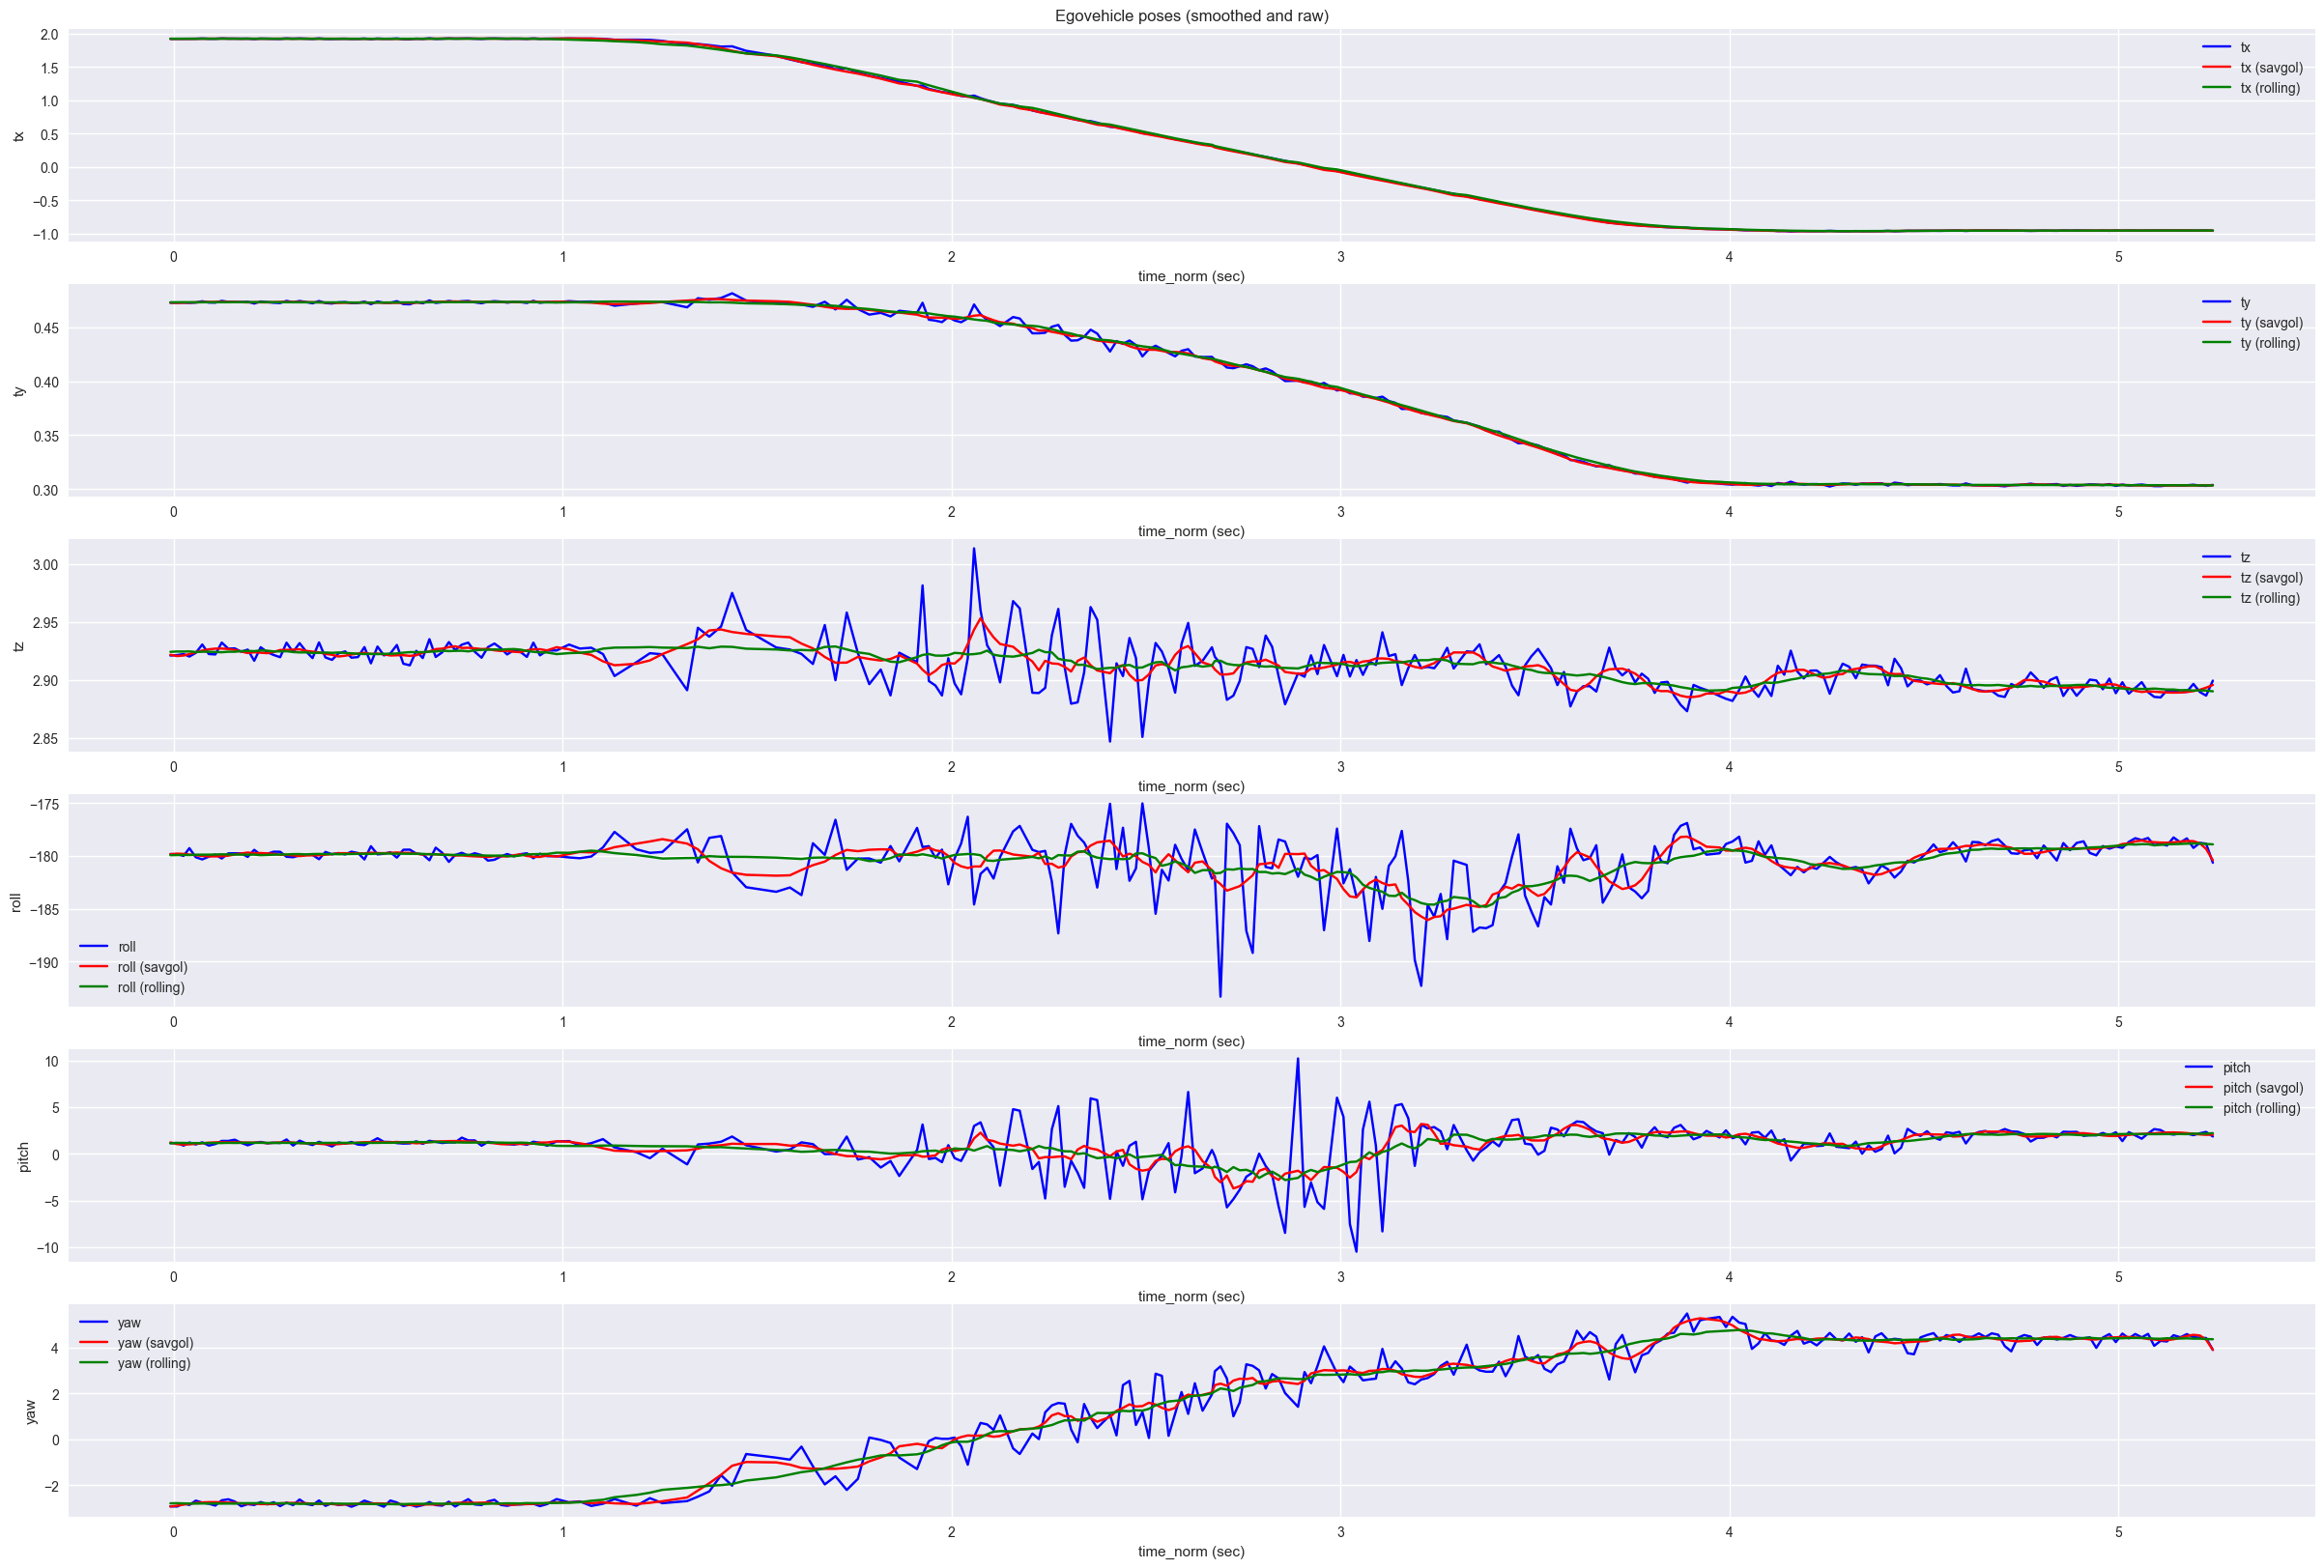

In [285]:
# plot the x and y positions
def plot_smoothed_data(run: dict, df_name: str, x_col: str, y_col: str):
  sns.lineplot(data=run[f"{df_name}"], x=x_col, y=f"{y_col}", label=y_col, color='blue')
  sns.lineplot(data=run[f"{df_name} (savgol)"], x=x_col, y=f"{y_col}", label=f"{y_col} (savgol)", color='red')
  sns.lineplot(data=run[f"{df_name} (rolling_mean)"], x=x_col, y=f"{y_col}", label=f"{y_col} (rolling)", color='green')

def plot_all_smoothed_poses(run: dict, df_name, x_col: str, columns: list[str]):
  fig = plt.figure(figsize=(30, 20))
  for i, col in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)
    if i == 0:
      plt.title("Egovehicle poses (smoothed and raw)")
    plot_smoothed_data(run, df_name, x_col, col)

plot_all_smoothed_poses(run2_data[9], "ego_bev_right_df", "time_norm (sec)", ["tx", "ty", "tz", "roll", "pitch", "yaw"])

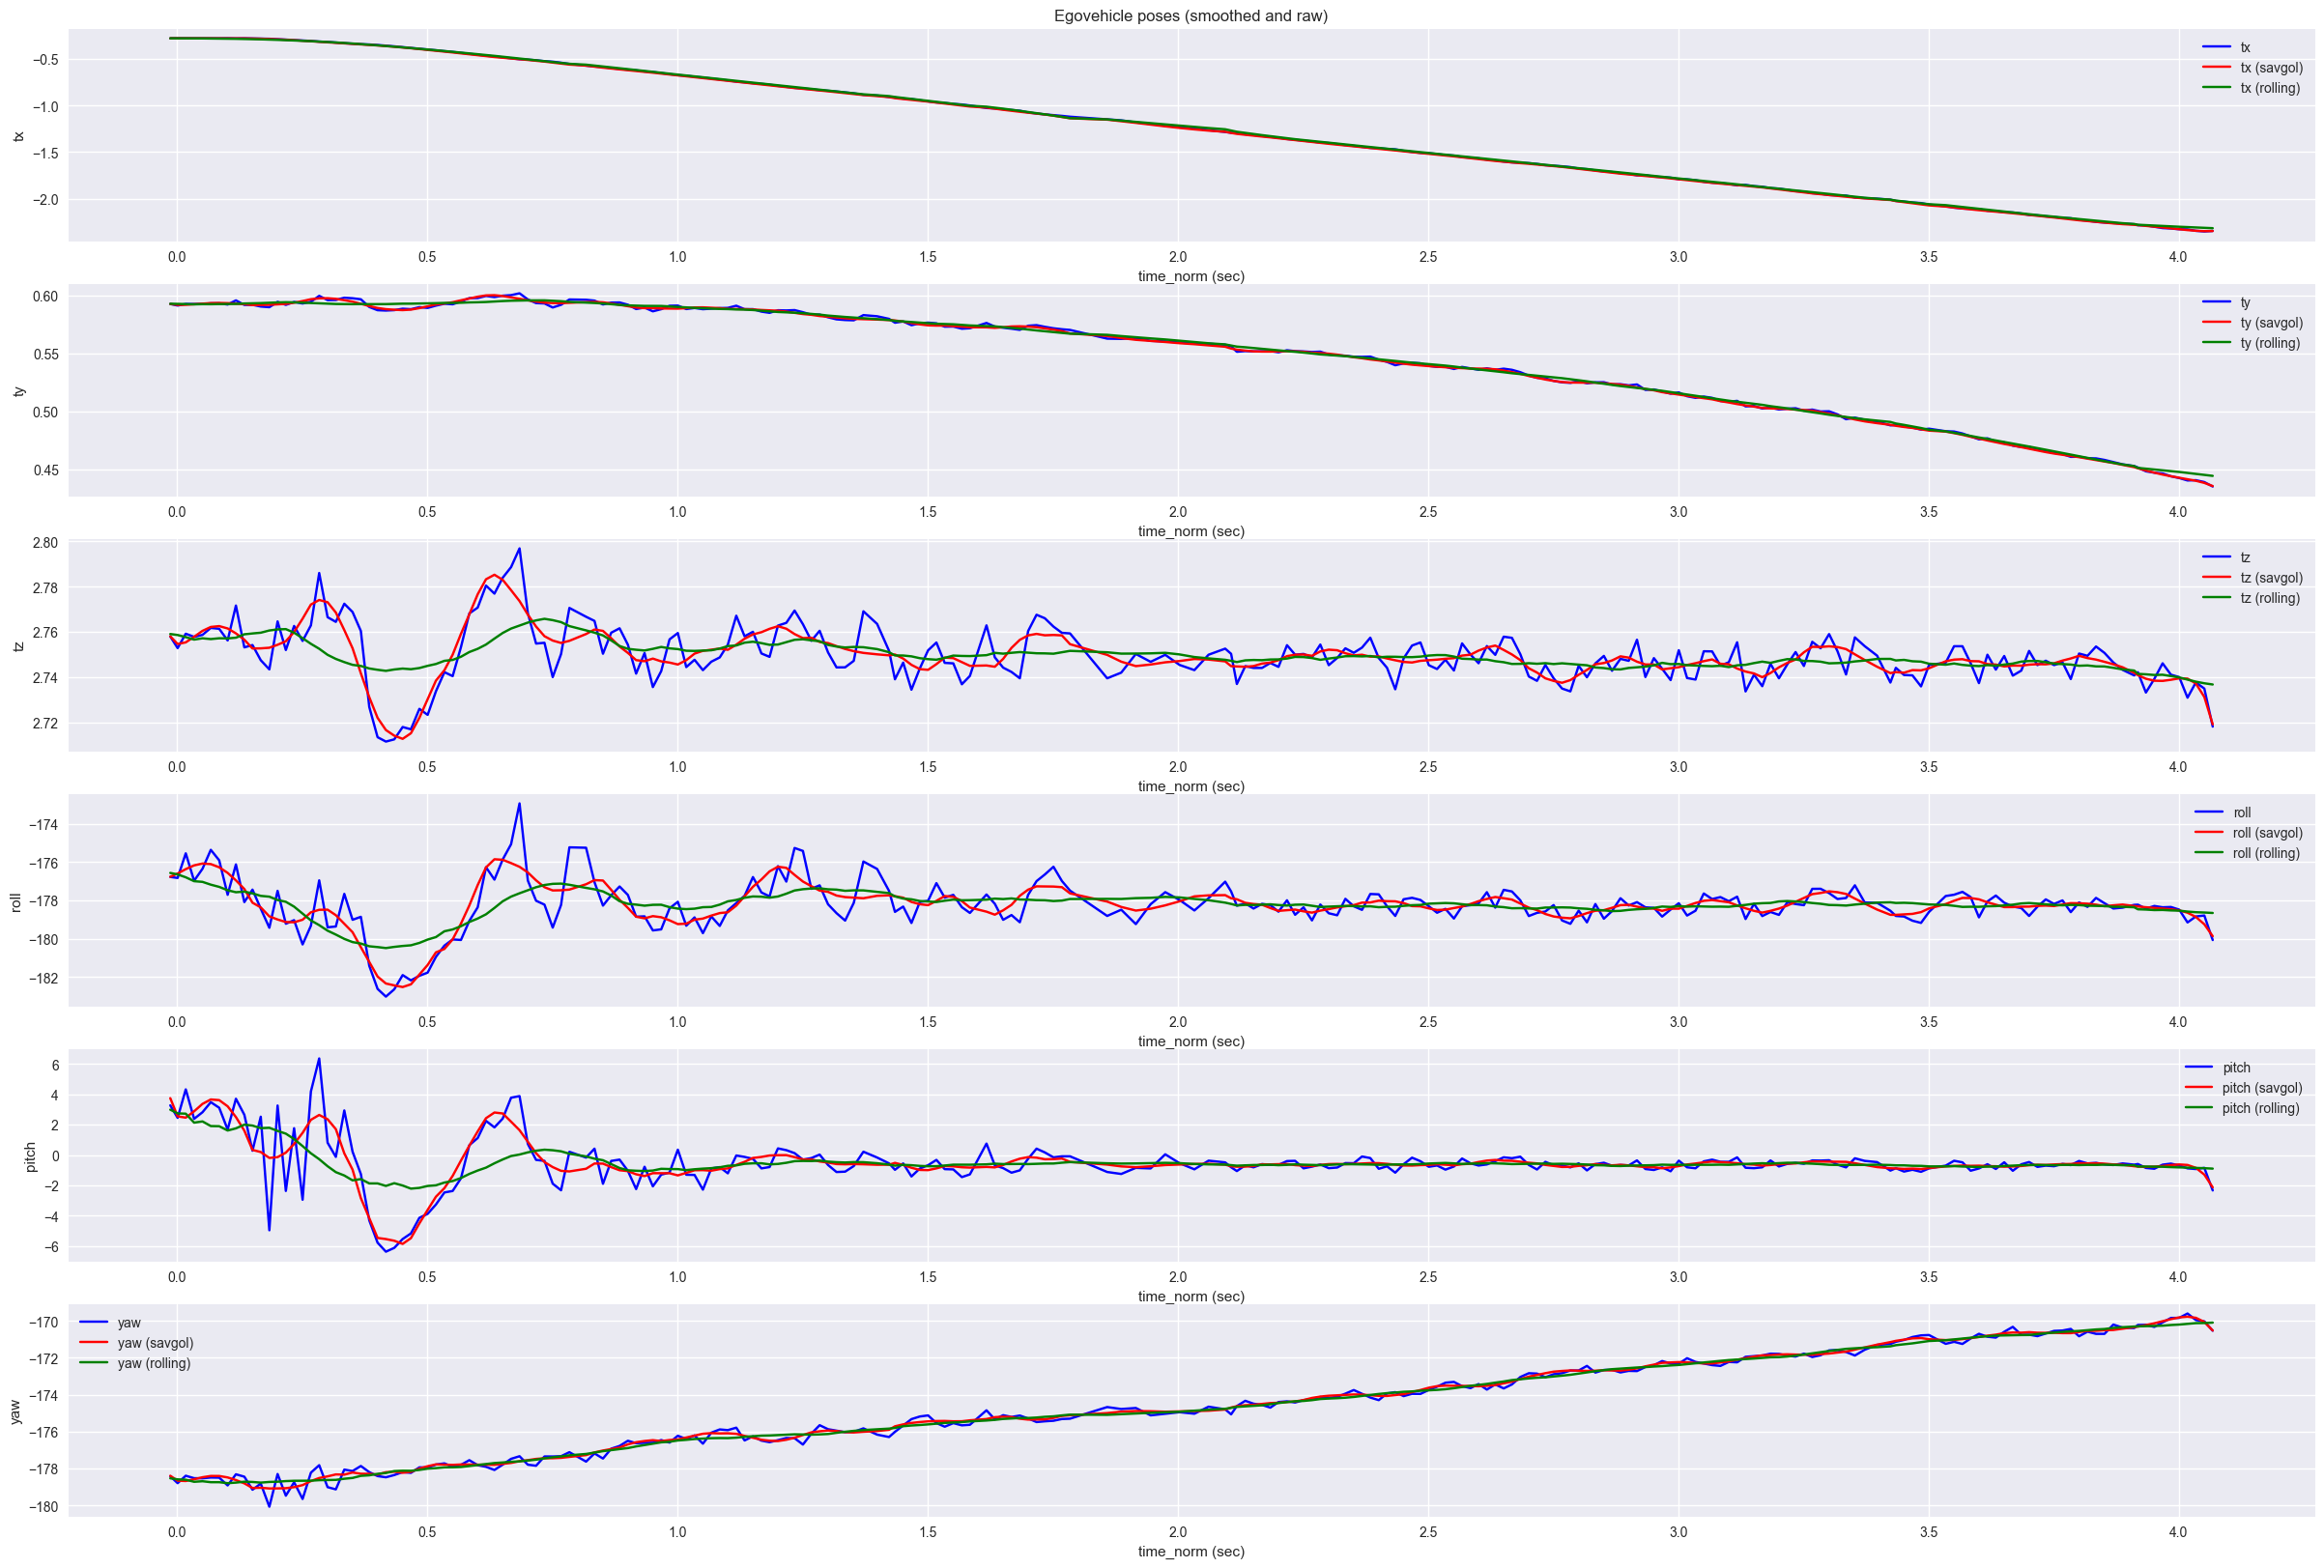

In [270]:
plot_all_smoothed_poses(run1_data[7], "opp_bev_right_df", "time_norm (sec)", ["tx", "ty", "tz", "roll", "pitch", "yaw"])

In [305]:
importlib.reload(ground_truth_real)
run2_data[3]["rel_poses_right_df"] = ground_truth_real.compute_relative_pose(run2_data[3]["ego_bev_right_df"], run2_data[3]["opp_bev_right_df"])
run2_data[3]["rel_poses_right_df"]

time (sec)  time_norm (sec)     rel_x     rel_y     rel_z    rel_roll  \
0    1.726393e+09        -0.009310  0.073646 -0.035634  2.211927 -177.670932   
1    1.726393e+09         0.006773  0.071945 -0.035226  2.211575 -177.705179   
2    1.726393e+09         0.023427  0.075694 -0.028140  2.209800 -177.678685   
3    1.726393e+09         0.040162  0.097590 -0.036525  2.213303 -177.120944   
4    1.726393e+09         0.056854  0.097239 -0.025934  2.208052 -177.155450   
..            ...              ...       ...       ...       ...         ...   
299  1.726393e+09         5.441123 -0.332430 -0.025622  0.706947  179.045692   
300  1.726393e+09         5.458497 -0.336562 -0.025900  0.709307  178.339976   
301  1.726393e+09         5.473905 -0.333257 -0.032743  0.702849  178.906928   
302  1.726393e+09         5.490577 -0.338137 -0.021750  0.709873  178.318094   
303  1.726393e+09         5.507419 -0.337664 -0.013013  0.714342  178.807874   

     rel_pitch    rel_yaw  
0    -0.011448  91.026992  
1    -0.002827  90.909416  
2    -0.305070  91.053256  
3    -0.048960  92.129347  
4    -0.322986  91.217867  
..         ...        ...  
299   0.662471  89.933046  
300   0.562464  91.272246  
301   0.912867  90.765538  
302   0.622279  90.788914  
303   0.462301  90.291972  

[304 rows x 8 columns]

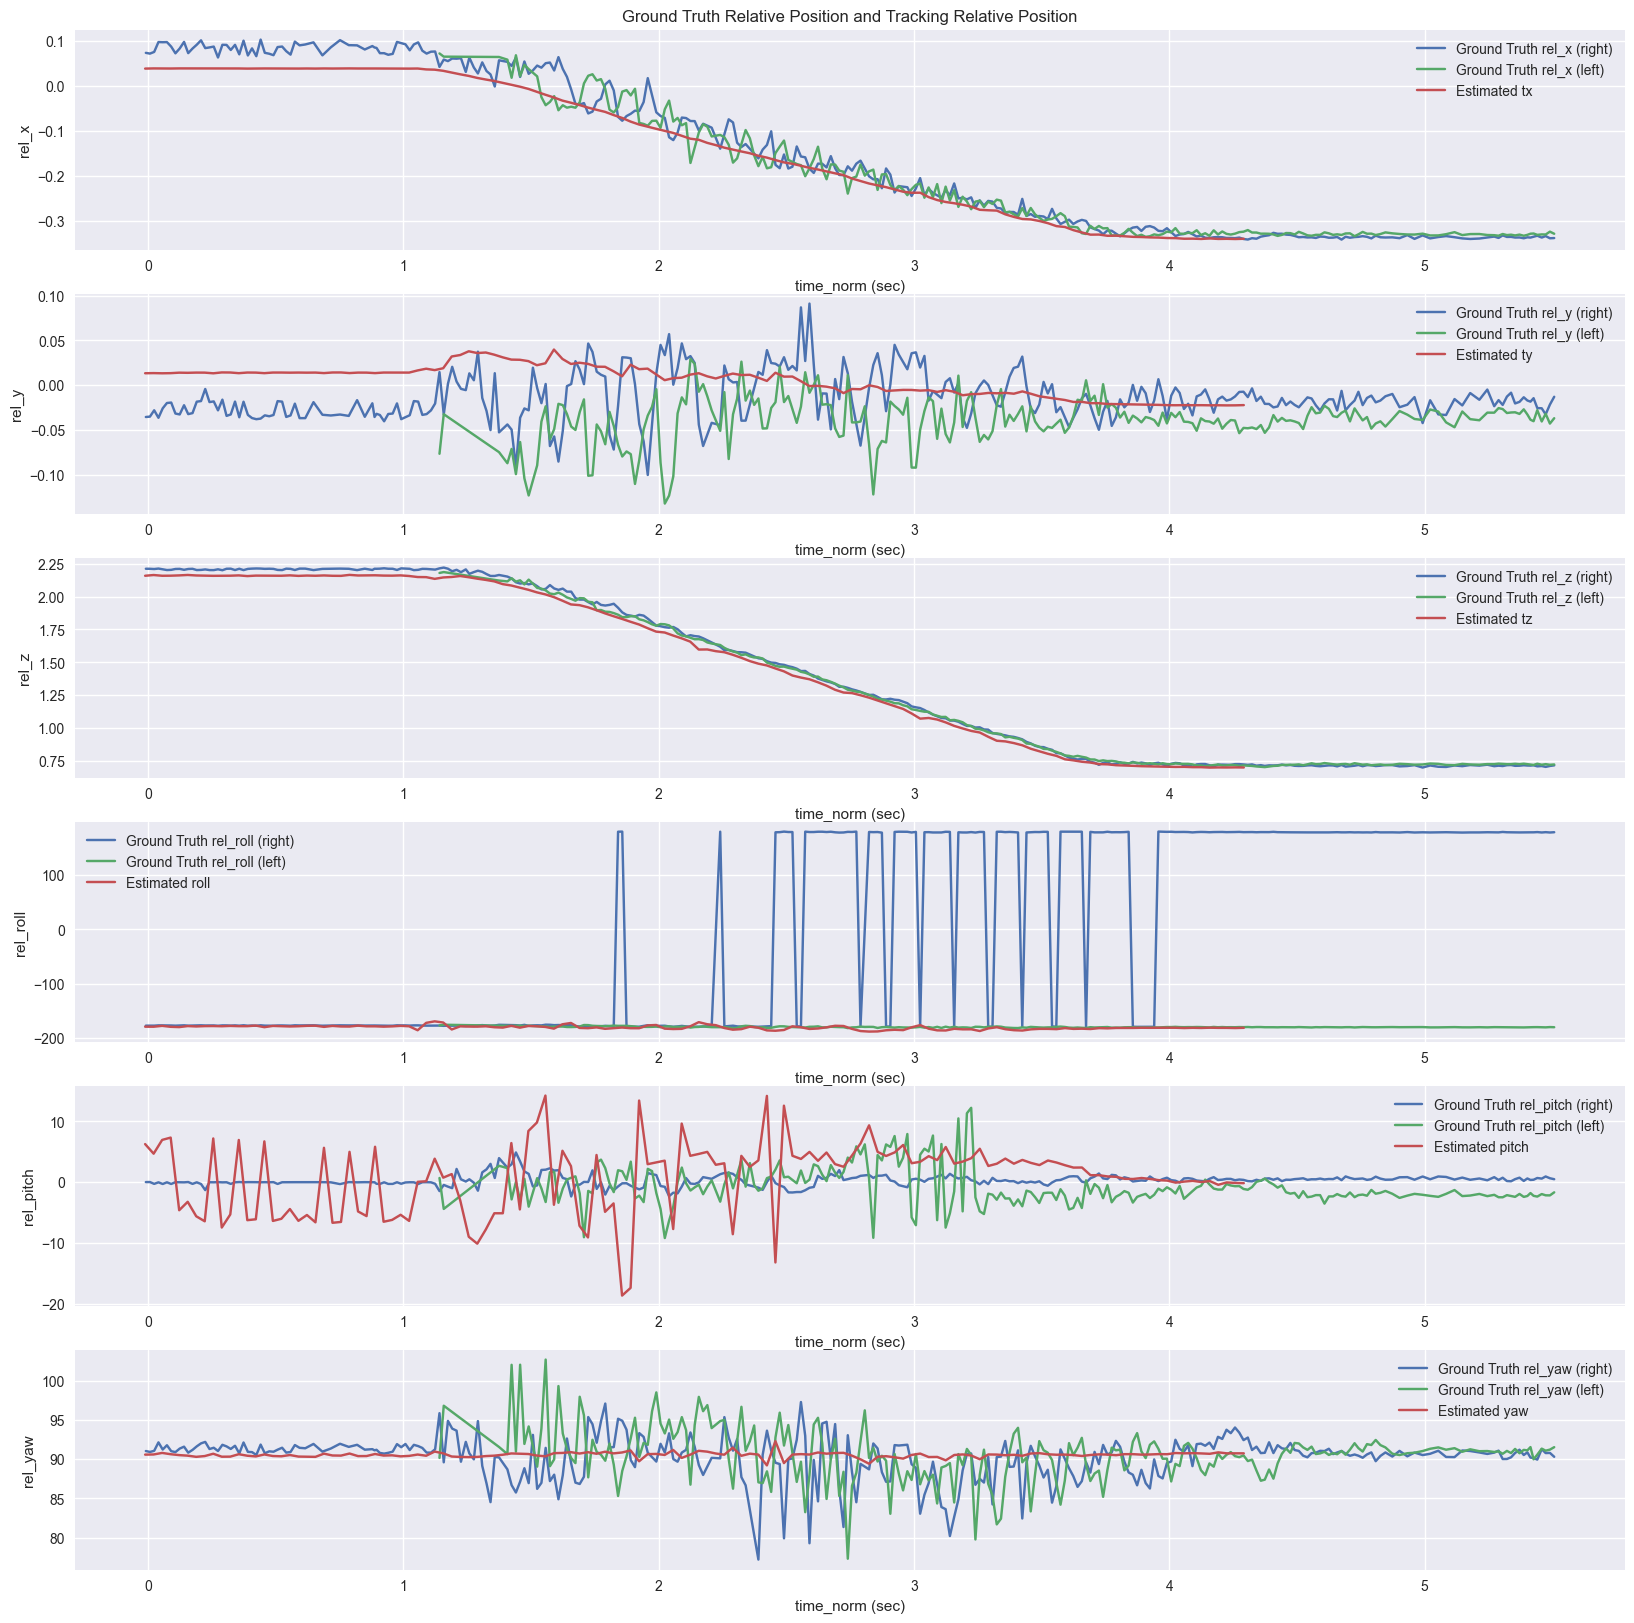

In [306]:
# plot the x and y positions
def plot_relative_position(run: dict):
  plt.figure(figsize=(20, 20))

  rel_cols = ["rel_x", "rel_y", "rel_z", "rel_roll", "rel_pitch", "rel_yaw"]
  cols = ["tx", "ty", "tz", "roll", "pitch", "yaw"]

  for i, (rel_col, col) in enumerate(zip(rel_cols, cols)):
    plt.subplot(len(cols), 1, i + 1)
    if i == 0:
      plt.title("Ground Truth Relative Position and Tracking Relative Position")

    sns.lineplot(data=run["rel_poses_right_df"], x="time_norm (sec)", y=rel_col, label=f"Ground Truth {rel_col} (right)")
    sns.lineplot(data=run["rel_poses_left_df"], x="time_norm (sec)", y=rel_col, label=f"Ground Truth {rel_col} (left)")
    sns.lineplot(data=run["tracking_df"], x="time_norm (sec)", y=col, label=f"Estimated {col}")
  # ax = plt.subplot(3, 1, 1)
  # plt.title("Ground Truth Relative Position and Tracking Relative Position")
  # # ax.set_ylim(0.4, 0.6)

  # sns.lineplot(x="time_norm (sec)", y="rel_x", data=run["rel_poses_right_df"], label="Ground Truth X (right)")
  # sns.lineplot(x="time_norm (sec)", y="rel_x", data=run["rel_poses_left_df"], label="Ground Truth X (left)")
  # sns.lineplot(x="time_norm (sec)", y="tx", data=run["tracking_df"], label="Estimated X")

  # ax = plt.subplot(3, 1, 2)
  # # ax.set_ylim(-0.5, 0.5)
  # sns.lineplot(x="time_norm (sec)", y="rel_y", data=run["rel_poses_right_df"], label="Ground Truth Y (right)")
  # sns.lineplot(x="time_norm (sec)", y="rel_y", data=run["rel_poses_left_df"], label="Ground Truth Y (left)")
  # sns.lineplot(x="time_norm (sec)", y="ty", data=run["tracking_df"], label="Estimated Y")

  # plt.subplot(3, 1, 3)
  # sns.lineplot(x="time_norm (sec)", y="rel_z", data=run["rel_poses_right_df"], label="Ground Truth Z (right)")
  # sns.lineplot(x="time_norm (sec)", y="rel_z", data=run["rel_poses_left_df"], label="Ground Truth Z (left)")
  # sns.lineplot(x="time_norm (sec)", y="tz", data=run["tracking_df"], label="Estimated Z")

plot_relative_position(run2_data[3])

In [62]:
from numpy.polynomial.polynomial import Polynomial

degree = 10
CONFIDENCE_INTERVAL = 0.95

def fit_model(df: pd.DataFrame, x_col: str, y_col: str, degree=1, confidence_interval=0.95):
  model: Polynomial = Polynomial.fit(df[x_col], df[y_col], degree)
  preds = model(df[x_col])
  residuals = df[y_col] - preds
  se = np.sqrt(sum(residuals ** 2) / (len(residuals) - degree - 1))
  z_score = stats.norm.ppf(1 - (1 - confidence_interval) / 2)
  confidence = z_score * se

  # get R-squared value
  ss_res = sum(residuals ** 2)
  ss_tot = sum((df[y_col] - np.mean(df[y_col])) ** 2)
  r_squared = 1 - (ss_res / ss_tot)

  return model, residuals, confidence, r_squared

tx_model, _, tx_confidence, tx_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tx", degree, CONFIDENCE_INTERVAL)
ty_model, _, ty_confidence, ty_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "ty", degree, CONFIDENCE_INTERVAL)
tz_model, _, tz_confidence, tz_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tz", degree, CONFIDENCE_INTERVAL)

tx_rolling_model, _, tx_rolling_confidence, tx_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tx (rolling)", degree, CONFIDENCE_INTERVAL)
ty_rolling_model, _, ty_rolling_confidence, ty_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "ty (rolling)", degree, CONFIDENCE_INTERVAL)
tz_rolling_model, _, tz_rolling_confidence, tz_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tz (rolling)", degree, CONFIDENCE_INTERVAL)

pitch_rolling_model, _, pitch_rolling_confidence, pitch_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "pitch (rolling)", degree, CONFIDENCE_INTERVAL)
roll_rolling_model, _, roll_rolling_confidence, roll_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "roll (rolling)", degree, CONFIDENCE_INTERVAL)
yaw_rolling_model, _, yaw_rolling_confidence, yaw_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "yaw (rolling)", degree, CONFIDENCE_INTERVAL)

rel_x_model, _, rel_x_confidence, rel_x_r2 = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_x", degree, CONFIDENCE_INTERVAL)
rel_y_model, _, rel_y_confidence, rel_y_r2 = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_y", 1, CONFIDENCE_INTERVAL)
rel_z_model, _, rel_z_confidence, rel_z_r2 = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_z", degree, CONFIDENCE_INTERVAL)

In [25]:
z_tx: pd.Series = stats.zscore(ego_bev_right_df['tx'])
z_tx = z_tx.apply(lambda x: abs(x))

z_ty: pd.Series = stats.zscore(ego_bev_right_df['ty'])
z_ty = z_ty.apply(lambda x: abs(x))

z_tz: pd.Series = stats.zscore(ego_bev_right_df['tz'])
z_tz = z_tz.apply(lambda x: abs(x))

# get all the unique indexes of the outliers
outliers = pd.concat((z_tx[z_tx > 3], z_ty[z_ty > 3], z_tz[z_tz > 3])).index.unique()
ego_bev_right_df.iloc[outliers]

time        qx        qy        qz        qw        ax  \
192  1726384506196617161 -0.999162  0.011434  0.030596  0.024670 -3.090596   
217  1726384506634124844 -0.999208  0.010007  0.026493  0.027968 -3.084411   
222  1726384506717811694 -0.999465  0.008030  0.018883  0.025483 -3.089970   

           ay        az        tx        ty  ...  pitch (rolling)  \
192  0.035367  0.094639 -0.367973  0.920245  ...         0.937766   
217  0.030889  0.081780 -0.612501  0.913918  ...         1.005625   
222  0.024827  0.058379 -0.660203  0.916140  ...         0.885831   

     pitch (savgol)  yaw (rolling)  yaw (savgol)  ax (rolling)  ay (rolling)  \
192        2.070907      -0.987151     -0.740877      3.137192     -0.026971   
217        1.861755      -0.685687     -0.524255      3.141060     -0.018789   
222        0.169462      -0.487590     -0.309381     -3.134692      0.013420   

     az (rolling)  ax (savgol)  ay (savgol)  az (savgol)  
192     -0.025732    -3.120981     0.020737     0.056209  
217     -0.027570    -3.116874     0.014871     0.050472  
222      0.024188    -3.132218     0.008478     0.004592  

[3 rows x 34 columns]

In [26]:
# rotate the rvec 90 degrees anticlockwise around the z axis
def rotate_rvec_90(rvec):
    R = cv2.Rodrigues(rvec)[0]
    R_rot = np.array([
        [0, 1, 0],
        [-1, 0, 0],
        [0, 0, 1]
    ])
    R_rotated = R @ R_rot
    return cv2.Rodrigues(R_rotated)[0]

In [123]:
ego_tx_model_s, ego_tx_model_v, ego_tx_model_a = ground_truth_real.fit_polynomial(run1_data[0]["ego_bev_right_df"], "time_norm (sec)", "tx", 8)
opp_tx_model_s, opp_tx_model_v, opp_tx_model_a = ground_truth_real.fit_polynomial(run1_data[0]["opp_bev_right_df"], "time_norm (sec)", "tx", 8)

np.polyval(ego_tx_model_v, run1_data[0]["ego_bev_right_df"]["time_norm (sec)"]), np.polyval(opp_tx_model_v, run1_data[0]["opp_bev_right_df"]["time_norm (sec)"])

(array([ 0.24109298,  0.19828174,  0.15721564,  0.11830723,  0.08034898,
         0.04446568,  0.01257159, -0.01944896, -0.05048844, -0.07985306,
        -0.10738974, -0.13511523, -0.15892656, -0.18416027, -0.20691138,
        -0.22923595, -0.25337716, -0.28419525, -0.31120358, -0.33577748,
        -0.35954003, -0.3825697 , -0.40369041, -0.42302651, -0.43975683,
        -0.45589243, -0.4692411 , -0.48156897, -0.49259615, -0.50203502,
        -0.50887059, -0.51253704, -0.51569107, -0.5177208 , -0.52122636,
        -0.52460155, -0.52763589, -0.53052022, -0.5355585 , -0.53771549,
        -0.53979704, -0.54171796, -0.54350652, -0.5451651 , -0.54672864,
        -0.5481172 , -0.54948524, -0.55064422, -0.55175623, -0.55283243,
        -0.55374875, -0.5545986 , -0.5554014 , -0.55615104, -0.55684967,
        -0.55750765, -0.55811023, -0.55868142, -0.55920808, -0.55971027,
        -0.56018455, -0.56063448, -0.56106562, -0.56147079, -0.56184234,
        -0.56221516, -0.56257432, -0.56291667, -0.5

In [140]:
test =ego_bev_right_df["tx"] 
# set the index of the dataframe to the time_norm column
test.index = ego_bev_right_df["time_norm (sec)"]
test

time_norm (sec)
-0.013628    1.336453
 0.001088    1.336386
 0.017316    1.332434
 0.034009    1.334268
 0.050779    1.334213
               ...   
 4.001034   -0.727819
 4.017605   -0.728368
 4.034239   -0.735529
 4.051171   -0.744207
 4.067951   -0.744452
Name: tx, Length: 232, dtype: float64

                               SARIMAX Results                                
Dep. Variable:                     tx   No. Observations:                  232
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 939.418
Date:                Sun, 29 Sep 2024   AIC                          -1866.836
Time:                        20:01:30   BIC                          -1846.155
Sample:                             0   HQIC                         -1858.496
                                - 232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3793      0.734      0.516      0.606      -1.060       1.819
ar.L1          1.2300      0.047     26.082      0.000       1.138       1.322
ar.L2          0.1069      0.089      1.199      0.2

/media/rl16432/Shared/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/media/rl16432/Shared/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/media/rl16432/Shared/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


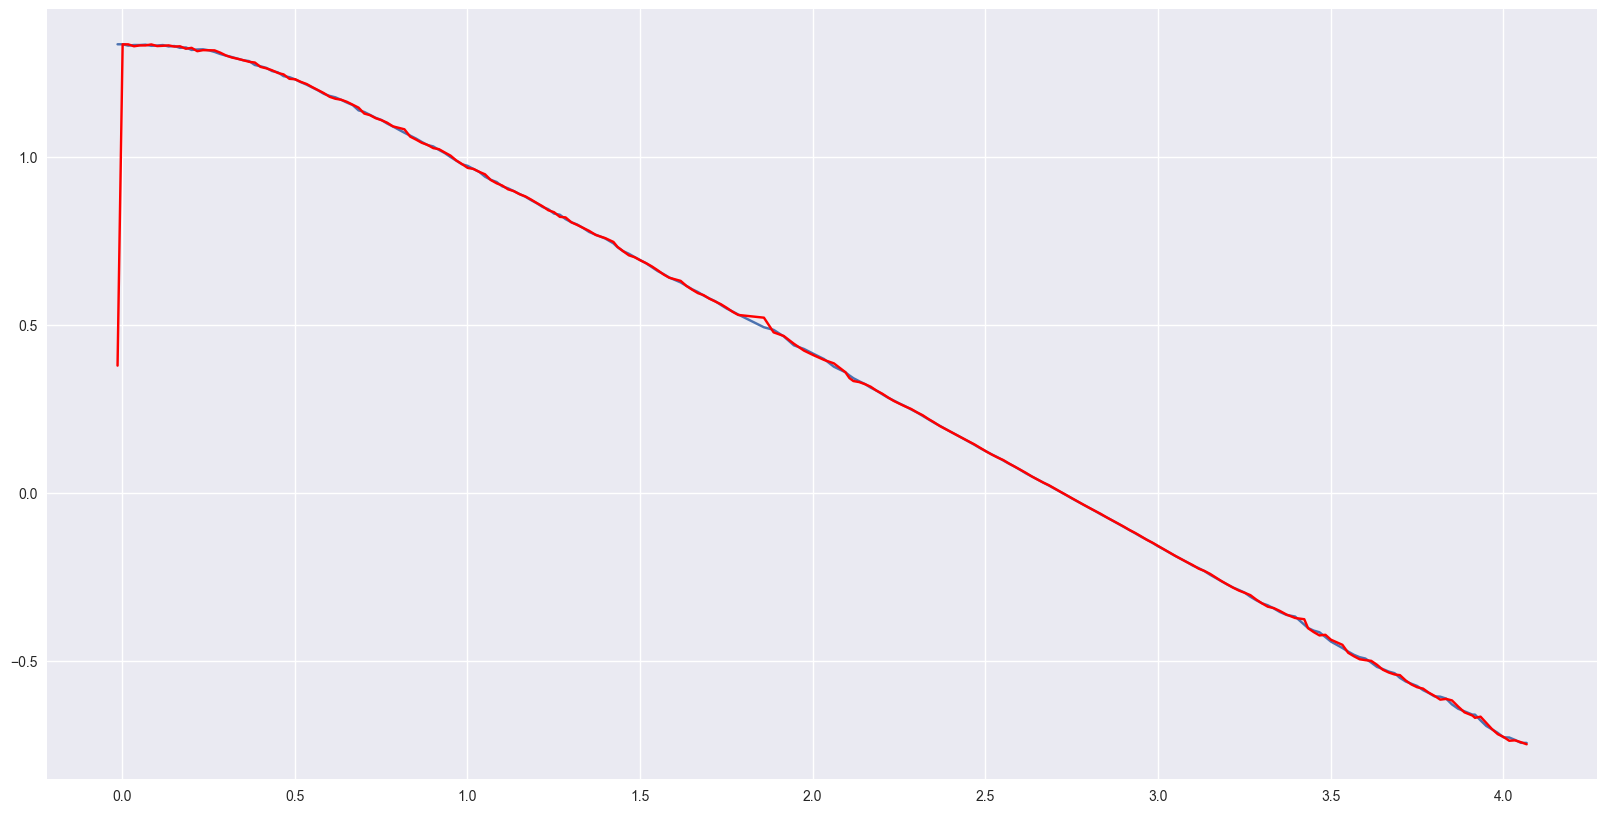

In [145]:
# fit arima model to the tx with respect to time
ego_bev_tx = ego_bev_right_df["tx"]
ego_bev_tx.index = ego_bev_right_df["time_norm (sec)"]
tx_arima_model = sm.tsa.ARIMA(ego_bev_tx, order=(4, 0, 0)).fit()
print(tx_arima_model.summary())

# plot the predicted values
plt.figure(figsize=(20, 10))
plt.plot(ego_bev_tx)
plt.plot(tx_arima_model.fittedvalues, color='red')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tx'>

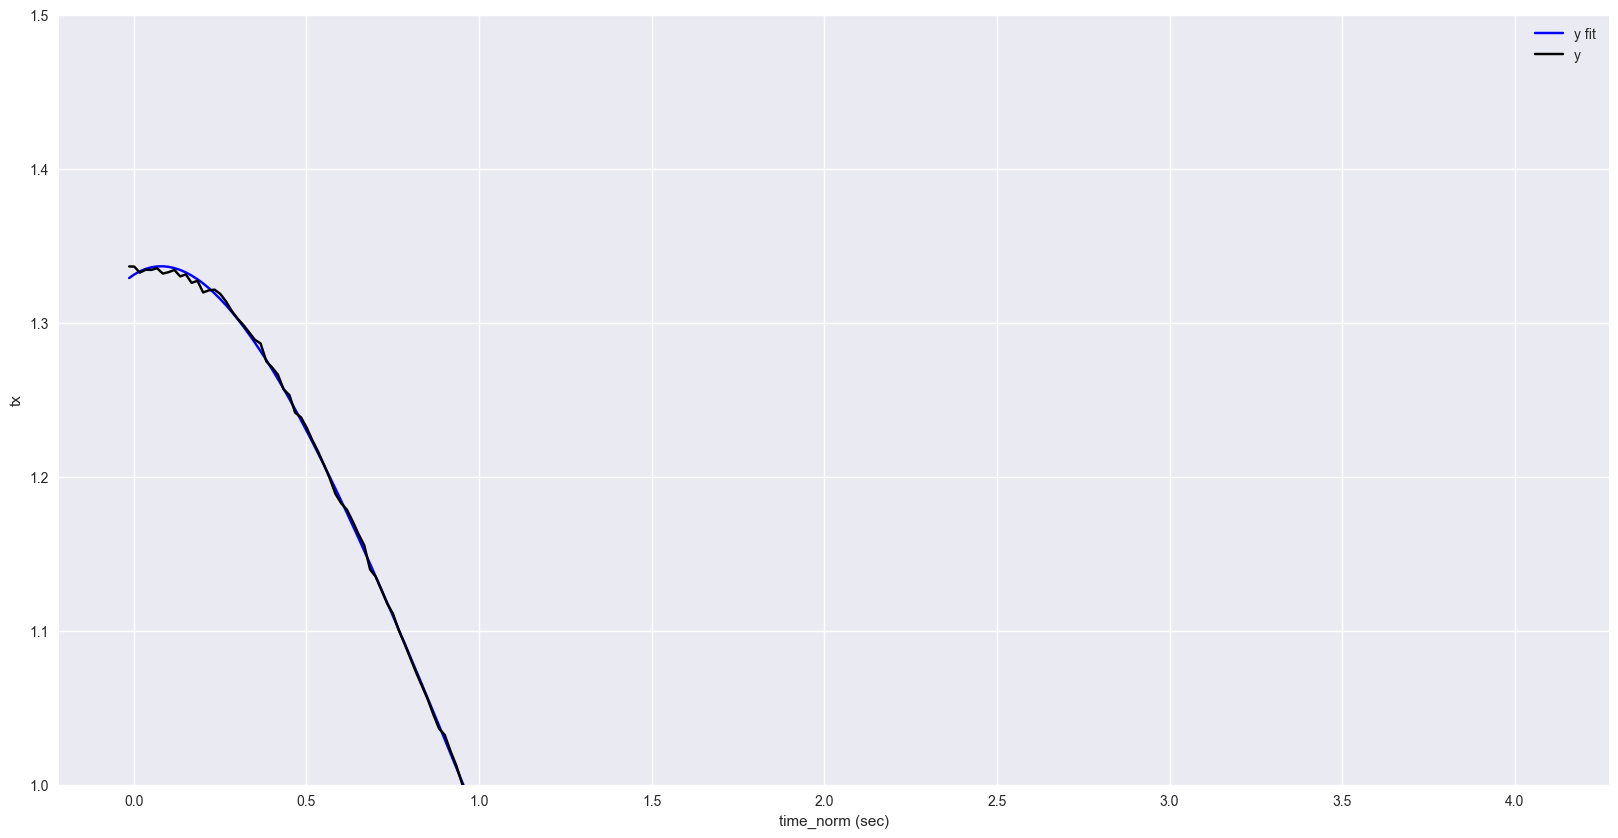

In [106]:
plt.figure(figsize=(20, 10))
# set y limits for the plots
plt.ylim(1, 1.5)

plt.plot(x, model_tx.predict(xp), label='y fit', markersize='5', color='blue')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='tx', label='y', color='black')

In [50]:
from numpy.polynomial.polynomial import Polynomial

degree = 3
CONFIDENCE_INTERVAL = 0.95

tx_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['tx'], degree)
ty_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['ty'], degree)
tz_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['tz'], 1)

In [51]:
tz_model.coef

array([ 2.93469373, -0.0100576 ])

In [52]:
tx_preds = tx_model(ego_bev_right_df['time_norm (sec)'])
ty_preds = ty_model(ego_bev_right_df['time_norm (sec)'])
tz_preds = tz_model(ego_bev_right_df['time_norm (sec)'])

tx_residuals = ego_bev_right_df['tx'] - tx_preds
ty_residuals = ego_bev_right_df['ty'] - ty_preds
tz_residuals = ego_bev_right_df['tz'] - tz_preds

# Standard error of the residuals
tx_se = np.sqrt(sum(tx_residuals ** 2) / (len(tx_residuals) - degree - 1))
ty_se = np.sqrt(sum(ty_residuals ** 2) / (len(ty_residuals) - degree - 1))
tz_se = np.sqrt(sum(tz_residuals ** 2) / (len(tz_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

# (tx_residuals.sum() / (len(tx_residuals) - degree-1))
# tx_se = np.std(tx_residuals)

tx_confidence = z_score * tx_se
ty_confidence = z_score * ty_se
tz_confidence = z_score * tz_se

tx_confidence, ty_confidence, tz_confidence

(0.029075969456155742, 0.02197020341373299, 0.02679651468049569)

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tz'>

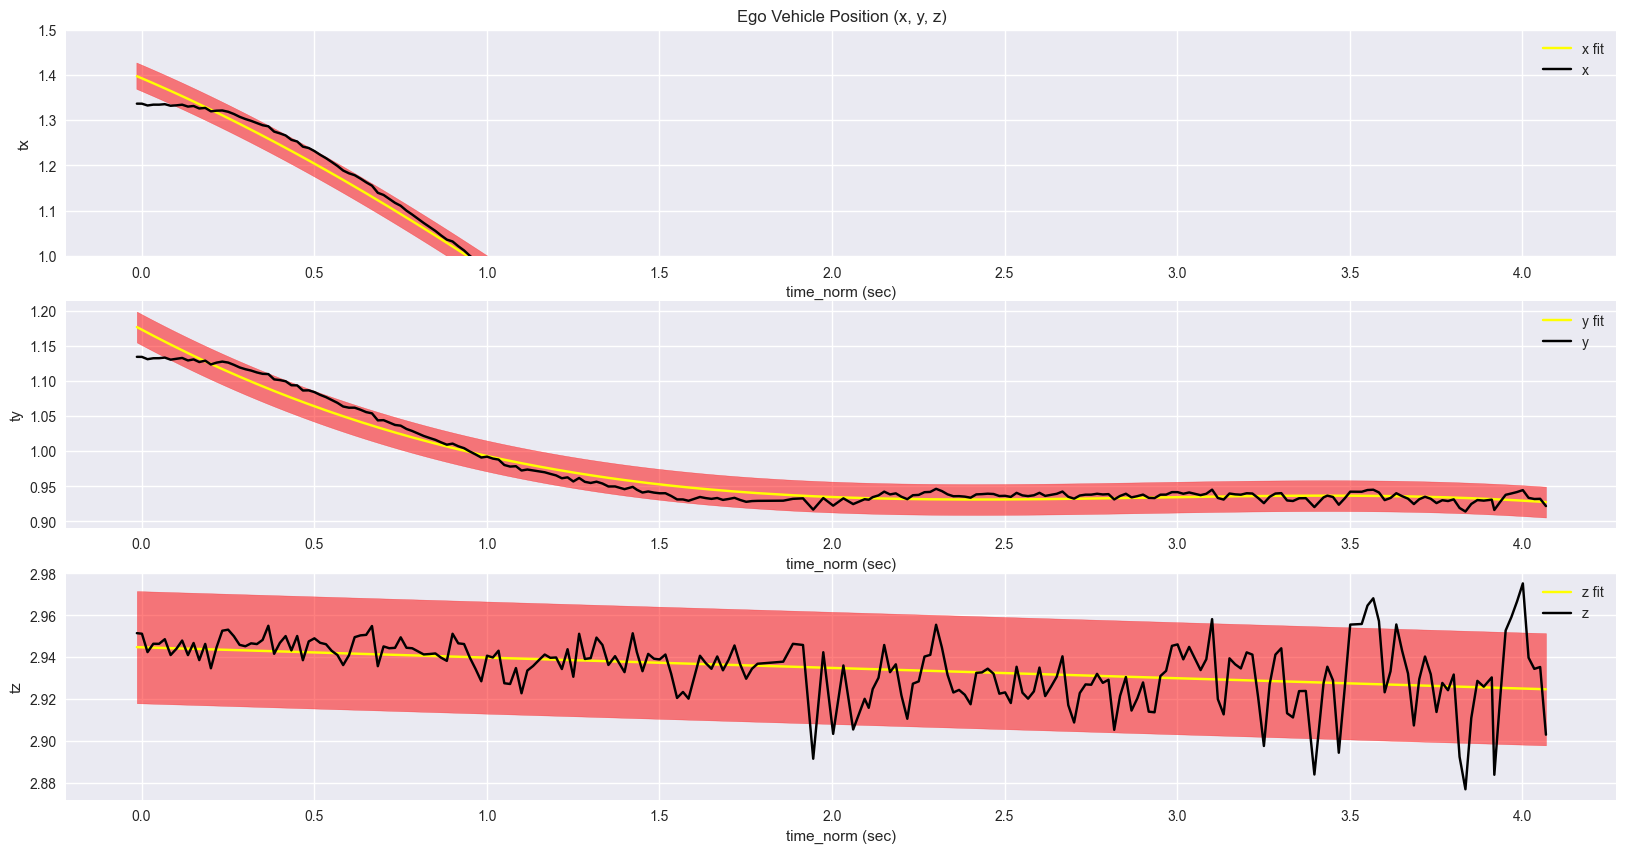

In [53]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

ax = plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Position (x, y, z)')
# ax.set_ylim(1.0, 1.5)
# plot the polynomial fit
plt.plot(ego_bev_right_df['time_norm (sec)'], tx_preds, label='x fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_right_df['time_norm (sec)'], tx_preds - tx_confidence, 
                    tx_preds + tx_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='tx', label='x', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_right_df['time_norm (sec)'], ty_preds, label='y fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], ty_preds - ty_confidence, 
                 ty_preds + ty_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='ty', label='y', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_right_df['time_norm (sec)'], tz_preds, label='z fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], tz_preds - tz_confidence, 
                 tz_preds + tz_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='tz', label='z', color='black')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tz'>

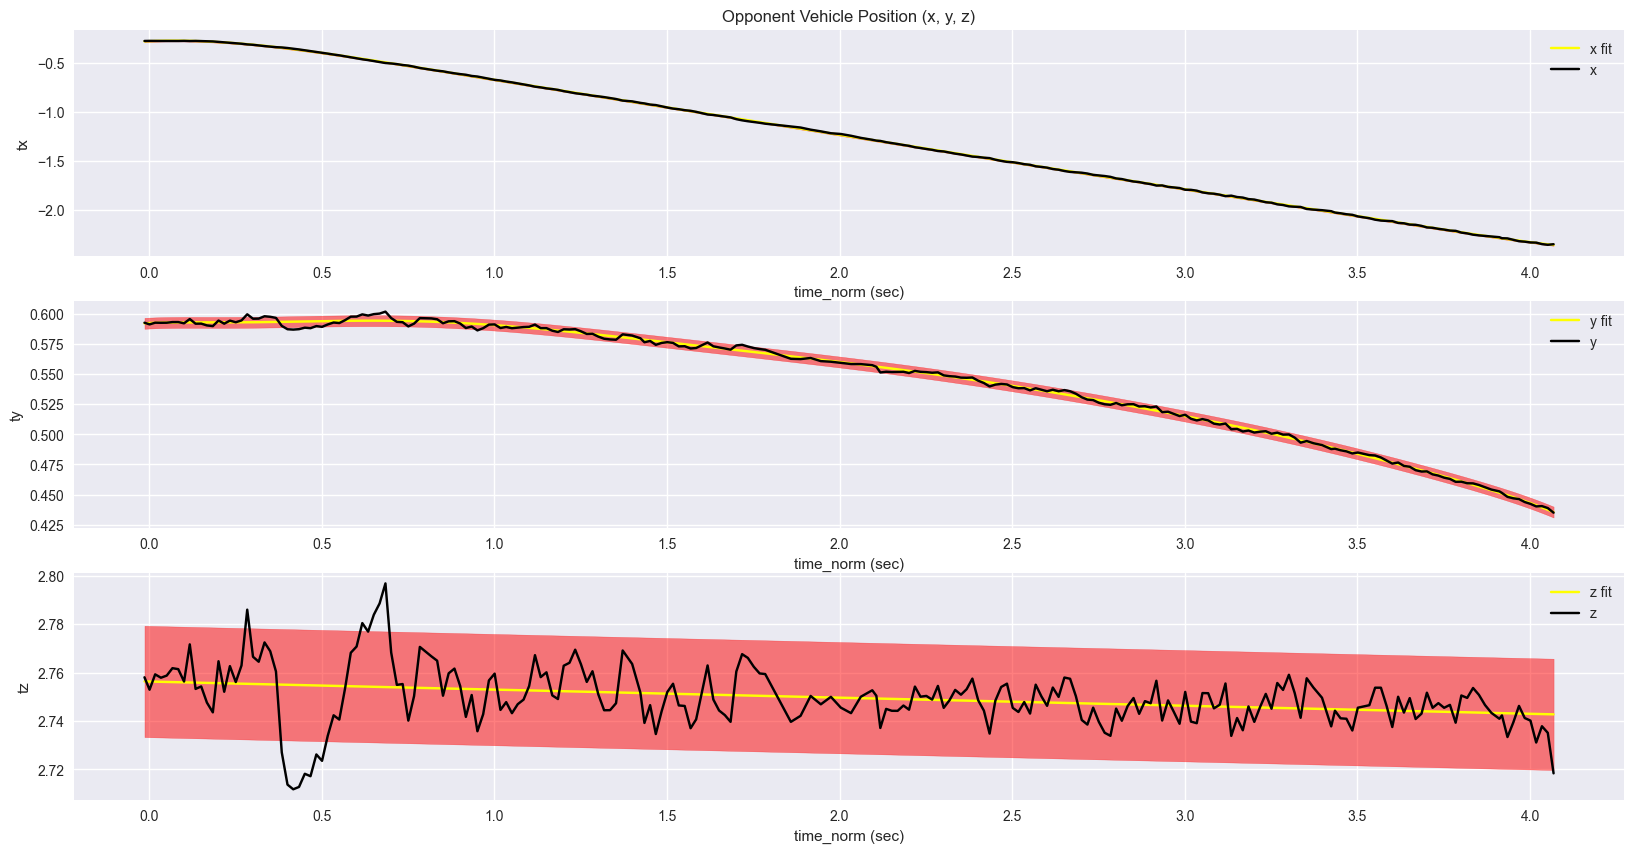

In [111]:
# plot the same for opp_bev_df
tx_model_opp: Polynomial = Polynomial.fit(opp_bev_right_df['time_norm (sec)'], opp_bev_right_df['tx'], degree)
ty_model_opp: Polynomial = Polynomial.fit(opp_bev_right_df['time_norm (sec)'], opp_bev_right_df['ty'], degree)
tz_model_opp: Polynomial = Polynomial.fit(opp_bev_right_df['time_norm (sec)'], opp_bev_right_df['tz'], 1)

tx_preds_opp = tx_model_opp(opp_bev_right_df['time_norm (sec)'])
ty_preds_opp = ty_model_opp(opp_bev_right_df['time_norm (sec)'])
tz_preds_opp = tz_model_opp(opp_bev_right_df['time_norm (sec)'])

tx_residuals_opp = opp_bev_right_df['tx'] - tx_preds_opp
ty_residuals_opp = opp_bev_right_df['ty'] - ty_preds_opp
tz_residuals_opp = opp_bev_right_df['tz'] - tz_preds_opp

tx_se_opp = np.sqrt(sum(tx_residuals_opp ** 2) / (len(tx_residuals_opp) - degree - 1))
ty_se_opp = np.sqrt(sum(ty_residuals_opp ** 2) / (len(ty_residuals_opp) - degree - 1))
tz_se_opp = np.sqrt(sum(tz_residuals_opp ** 2) / (len(tz_residuals_opp) - degree - 1))

tx_confidence_opp = z_score * tx_se_opp
ty_confidence_opp = z_score * ty_se_opp
tz_confidence_opp = z_score * tz_se_opp

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Opponent Vehicle Position (x, y, z)')
plt.plot(opp_bev_right_df['time_norm (sec)'], tx_preds_opp, label='x fit', markersize='5', color='yellow')

plt.fill_between(opp_bev_right_df['time_norm (sec)'], tx_preds_opp - tx_confidence_opp,
                  tx_preds_opp + tx_confidence_opp, alpha=0.5, color='red')
sns.lineplot(data=opp_bev_right_df, x='time_norm (sec)', y='tx', label='x', color='black')

plt.subplot(3, 1, 2)
plt.plot(opp_bev_right_df['time_norm (sec)'], ty_preds_opp, label='y fit', markersize='5', color='yellow')
plt.fill_between(opp_bev_right_df['time_norm (sec)'], ty_preds_opp - ty_confidence_opp,
                 ty_preds_opp + ty_confidence_opp, alpha=0.5, color='red')
sns.lineplot(data=opp_bev_right_df, x='time_norm (sec)', y='ty', label='y', color='black')

plt.subplot(3, 1, 3)
plt.plot(opp_bev_right_df['time_norm (sec)'], tz_preds_opp, label='z fit', markersize='5', color='yellow')
plt.fill_between(opp_bev_right_df['time_norm (sec)'], tz_preds_opp - tz_confidence_opp,
                 tz_preds_opp + tz_confidence_opp, alpha=0.5, color='red')
sns.lineplot(data=opp_bev_right_df, x='time_norm (sec)', y='tz', label='z', color='black')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='yaw'>

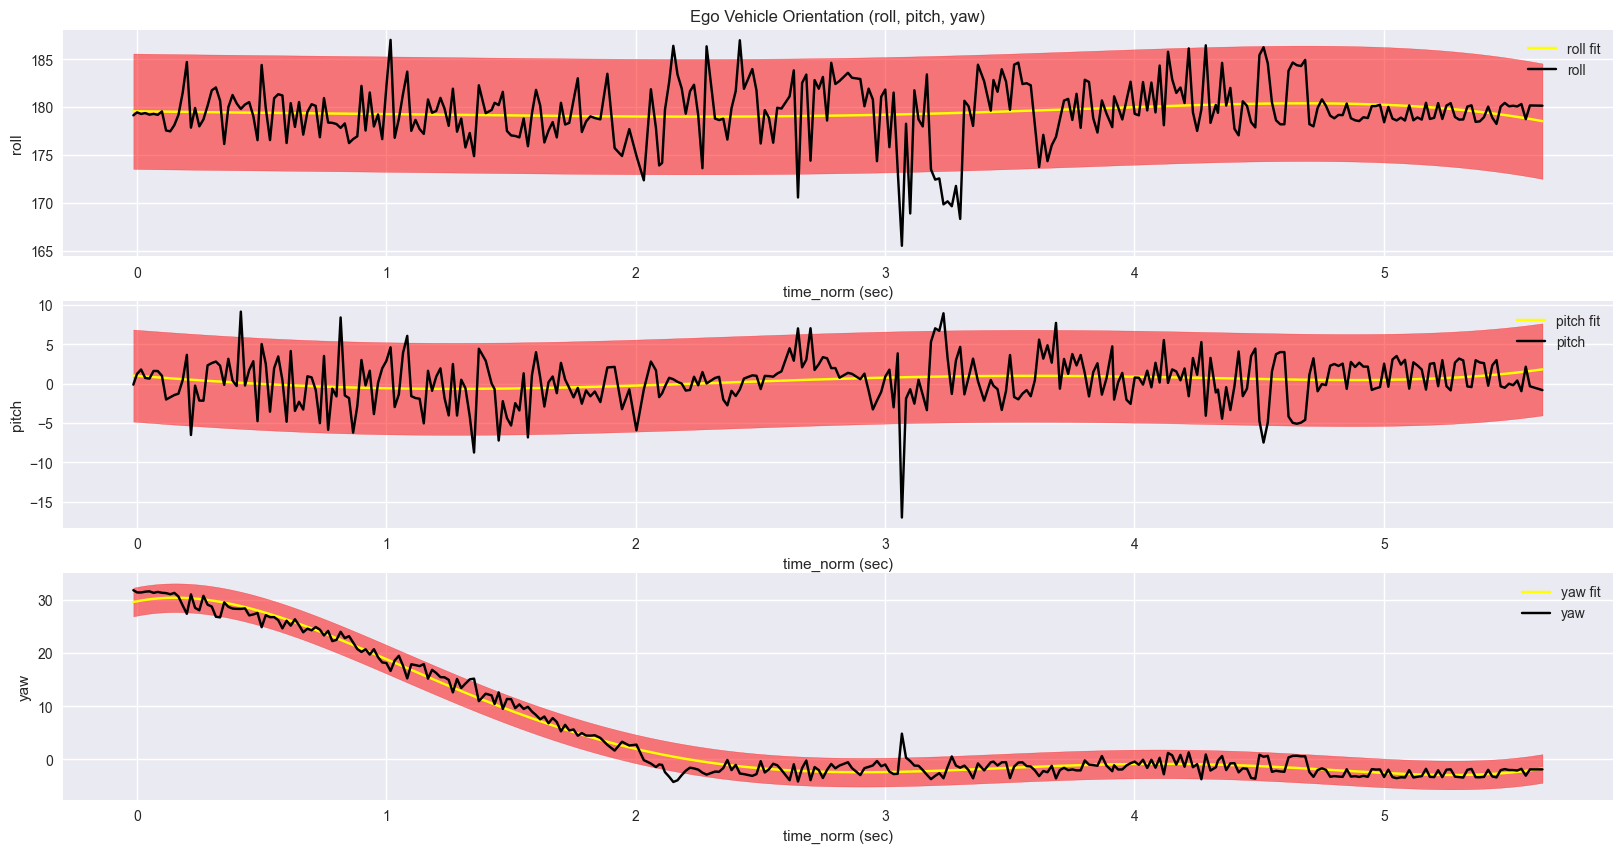

In [25]:
# plot the euler angles of ego_bev_df in the same way
degree = 5
roll_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['roll'], degree)
pitch_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['pitch'], degree)
yaw_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['yaw'], degree)

roll_preds = roll_model(ego_bev_right_df['time_norm (sec)'])
pitch_preds = pitch_model(ego_bev_right_df['time_norm (sec)'])
yaw_preds = yaw_model(ego_bev_right_df['time_norm (sec)'])

roll_residuals = ego_bev_right_df['roll'] - roll_preds
pitch_residuals = ego_bev_right_df['pitch'] - pitch_preds
yaw_residuals = ego_bev_right_df['yaw'] - yaw_preds

roll_se = np.sqrt(sum(roll_residuals ** 2) / (len(roll_residuals) - degree - 1))
pitch_se = np.sqrt(sum(pitch_residuals ** 2) / (len(pitch_residuals) - degree - 1))
yaw_se = np.sqrt(sum(yaw_residuals ** 2) / (len(yaw_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

roll_confidence = z_score * roll_se
pitch_confidence = z_score * pitch_se
yaw_confidence = z_score * yaw_se

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Orientation (roll, pitch, yaw)')
# plot the polynomial fit
plt.plot(ego_bev_right_df['time_norm (sec)'], roll_preds, label='roll fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_right_df['time_norm (sec)'], roll_preds - roll_confidence, 
                    roll_preds + roll_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='roll', label='roll', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_right_df['time_norm (sec)'], pitch_preds, label='pitch fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], pitch_preds - pitch_confidence, 
                 pitch_preds + pitch_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='pitch', label='pitch', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_right_df['time_norm (sec)'], yaw_preds, label='yaw fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], yaw_preds - yaw_confidence, 
                 yaw_preds + yaw_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='yaw', label='yaw', color='black')

In [45]:
ego_bev_right_df[ego_bev_right_df["rel_x"]]

KeyError: 'rel_x'

[[700.67498779   0.         628.23999023]
 [  0.         700.67498779 350.07598877]
 [  0.           0.           1.        ]] [[541.27227994   0.         623.99757244]
 [  0.         539.36284999 348.98083539]
 [  0.           0.           1.        ]]
(array([[[585.8879 , 477.8919 ],
        [555.97156, 478.05057],
        [556.05725, 448.06726],
        [586.0482 , 447.97003]]], dtype=float32), array([[[867.9543 , 536.2043 ],
        [891.893  , 550.5157 ],
        [877.737  , 574.36304],
        [853.79785, 559.7453 ]]], dtype=float32))
[14] [[-0.26603857]
 [ 0.574333  ]
 [ 2.71728121]] (-178.2463324761826, 1.719225381546346, -179.88288548589625)
[14] [[-0.26576697]
 [ 0.57361042]
 [ 2.71724804]] (-157.76536374370477, 9.085284746037443, -178.31216574017645)

[12] [[1.35007567]
 [1.12278239]
 [2.93662171]] (179.38355273773604, 1.245244833849249, 31.11947159259748)
[12] [[1.34902176]
 [1.12193348]
 [2.93710725]] (165.5949771691849, 59.36060850205624, 22.635917452159948)

[[700.674987

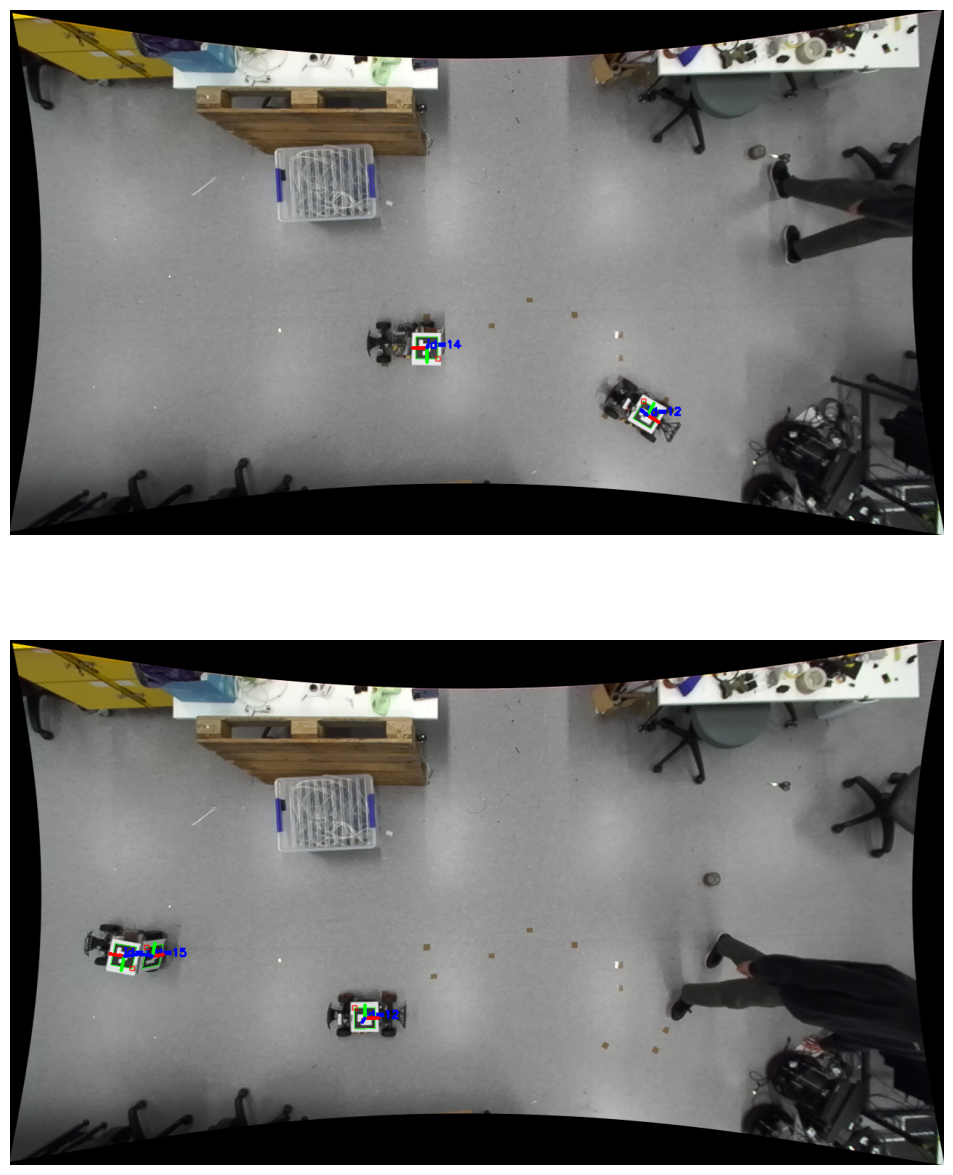

In [226]:
import perception.util.aruco as aruco
run_num = 7
num = 0
image_prev = cv2.imread(f'{run1_data[run_num]["bev_path"]}/bev/right/{run1_data[run_num]["ego_bev_right_df"]["time"].iloc[num - 1]}.png')

image = cv2.imread(f'{run1_data[run_num]["bev_path"]}/bev/right/{run1_data[run_num]["ego_bev_right_df"]["time"].iloc[num]}.png')
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

intrinsics = np.loadtxt(f'{run1_data[6]["bev_path"]}/bev/right/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run1_data[6]["bev_path"]}/bev/right/dist_coeffs.txt')
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_APRILTAG
# detector_params.cornerRefinementMinAccuracy = 0.1
def draw_markers_on_image(image, intrinsics, dist_coeffs):
  new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
  undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)
  print(intrinsics, new_intrinsics)
  und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)
  print(und_corners)

  drawn_image = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)

  for corner, id in zip(und_corners, und_ids):
    _, rvecs_und, tvecs_und, reproj_error = cv2.solvePnPGeneric(marker_obj_points, corner, new_intrinsics, None, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    for rvec_und, tvec_und in zip(rvecs_und, tvecs_und):
      # rvec_und = conv.get_rodrigues_from_euler(45,0,0, degrees=True)
      # rvec_und = conv.get_rodrigues_from_euler(20, 20, 20, degrees=True)
      quat = conv.get_quaternion_from_rodrigues(rvec_und)
      euler_und = conv.get_euler_from_quaternion(*quat, degrees=True)
      print(id, tvec_und, euler_und)
    
    print("")
    cv2.drawFrameAxes(drawn_image, new_intrinsics, None, rvec_und, tvec_und, 0.1)
  
  return drawn_image

drawn_image = draw_markers_on_image(image, intrinsics, dist_coeffs)
drawn_image_prev = draw_markers_on_image(image_prev, intrinsics, dist_coeffs)

plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(cv2.cvtColor(drawn_image_prev, cv2.COLOR_BGR2RGB))